Total Number of words: 2185

**Introduction**

The dataset chosen to analyse is classification of breast cancer images, the dataset is analysed with both deep learning models and machine learning models. The deep learning models chosen are CNN-LSTM, CNN, Vanilla ANN and LSTM. The machine learning models that have been chosen for this analysis are Random Forest, KNN and Naive Bayes.


Essential libraries are installed.

**bold text**


In [ ]:
!pip install mahotas
!pip install scikeras[tensorflow]
!pip install tqdm
!pip install joblib pydrive

Essential Libraries are imported and function for seed is added.

In [ ]:
import os
os.environ['PYTHONHASHSEED']=str(1)
import random
from tqdm import tqdm
import joblib
import cv2
from joblib import parallel_backend

import numpy as np
import matplotlib.pylab as plt
import h5py
import seaborn as sns
from sklearn.cluster import KMeans

from skimage import exposure, transform, util
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score,classification_report, cohen_kappa_score, roc_auc_score, roc_curve, matthews_corrcoef, f1_score, precision_recall_curve, average_precision_score,auc
from sklearn.model_selection import GridSearchCV
from skimage.feature import hog
from skimage.transform import resize
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn import svm,metrics
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, TimeDistributed, Input, BatchNormalization, Dropout, LSTM,Reshape
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import normalize, to_categorical
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adagrad
from scikeras.wrappers import KerasClassifier



def set_seed(seed=1):
   os.environ['PYTHONHASHSEED']=str(seed)
   tf.random.set_seed(seed)
   np.random.seed(seed)
   random.seed(seed)


**Preliminary Action**
The data is loaded, and the shapes of the images are investigated. There are a total of 5547 images with labels.2788 positive case images and 2759 negative case images. Overall it is a balanced dataset.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
train_images = np.load('/content/drive/My Drive/breast_histology/X.npy')
test_labels = np.load('/content/drive/My Drive/breast_histology/Y.npy')
print("Shape of test_labels:", test_labels.shape)
print("Shape of train_images:", train_images.shape)

positive_cases = train_images[test_labels==1]
negative_cases = train_images[test_labels==0]

print("Shape of positive_cases:", positive_cases.shape)
print("Shape of negative_cases:", negative_cases.shape)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Shape of test_labels: (5547,)
Shape of train_images: (5547, 50, 50, 3)
Shape of positive_cases: (2788, 50, 50, 3)
Shape of negative_cases: (2759, 50, 50, 3)


**EDA**

---



Sample images are plotted to understand the characteristics of the image. The dataset is then split into 3 splits for the purpose of training, testing and validation and there shapes are analysed.

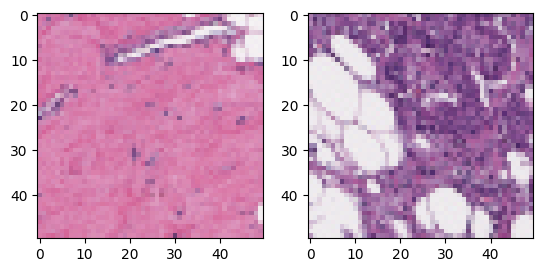

In [ ]:
plt.subplot(1,2,1)
plt.imshow(negative_cases[65])
plt.subplot(1,2,2)
plt.imshow(positive_cases[43])

train_images, temp_images, train_labels, temp_labels = train_test_split(
    train_images, test_labels, test_size=0.3, random_state=42, stratify=test_labels)

val_images, test_images, val_labels, test_labels = train_test_split(
    temp_images, temp_labels, test_size=0.5, random_state=42, stratify=temp_labels)

**Blurness**
blur values of the images are calculated using the Laplacian variance.The dataset is reasonably sharp with only one image less than 100 blur value.




Number of blurry images: 1
4765.839973130757
241 3449


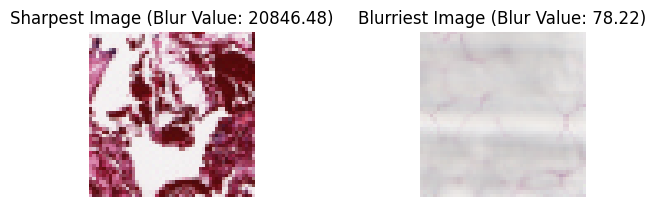

In [ ]:
def calculate_blur(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    laplacian_var = cv2.Laplacian(gray, cv2.CV_64F).var()
    return laplacian_var

blur_val = [calculate_blur(image) for image in train_images]
threshold = 100
blurry_img_count = sum(1 for value in blur_val if value < threshold)
print(f"Number of blurry images: {blurry_img_count}")
mean_blur = np.mean(blur_val)
print(mean_blur)


sharpest_index = np.argmax(blur_val)
blurriest_index = np.argmin(blur_val)
print(sharpest_index, blurriest_index)

plt.subplot(1, 2, 1)
plt.title(f'Sharpest Image (Blur Value: {blur_val[sharpest_index]:.2f})')
plt.imshow(train_images[sharpest_index])
plt.axis('off')

# Display the blurriest image
plt.subplot(1, 2, 2)
plt.title(f'Blurriest Image (Blur Value: {blur_val[blurriest_index]:.2f})')
plt.imshow(train_images[blurriest_index])
plt.axis('off')

plt.subplots_adjust(wspace=1)


plt.show()

**Pixel Intensity**
The pixel range is from 0-255, pixel intensity histogram is plotted. he pixel values over 200 have the highest frequencies within the images.

Mean pixel intensity: 184.82
Standard deviation of pixel intensity: 47.23


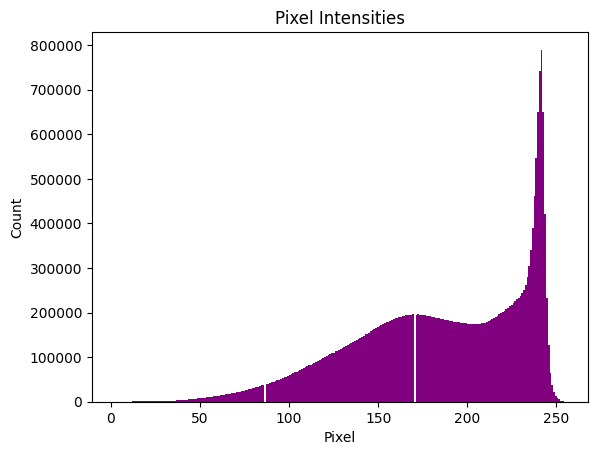

In [ ]:
mean_intensity = np.mean(train_images)
std_intensity = np.std(train_images)

print(f"Mean pixel intensity: {mean_intensity:.2f}")
print(f"Standard deviation of pixel intensity: {std_intensity:.2f}")

plt.hist(train_images.ravel(), bins=256, color='purple')
plt.title('Pixel Intensities')
plt.xlabel('Pixel')
plt.ylabel('Count')
plt.show()

**RGB Color Intensity**
RGB color intensity plot is drawn for both positive and negative cases.RGB intensity of negative case images are fairly distributed much better than the positive case images.
The outliers are much higher in positive images than in negative images.


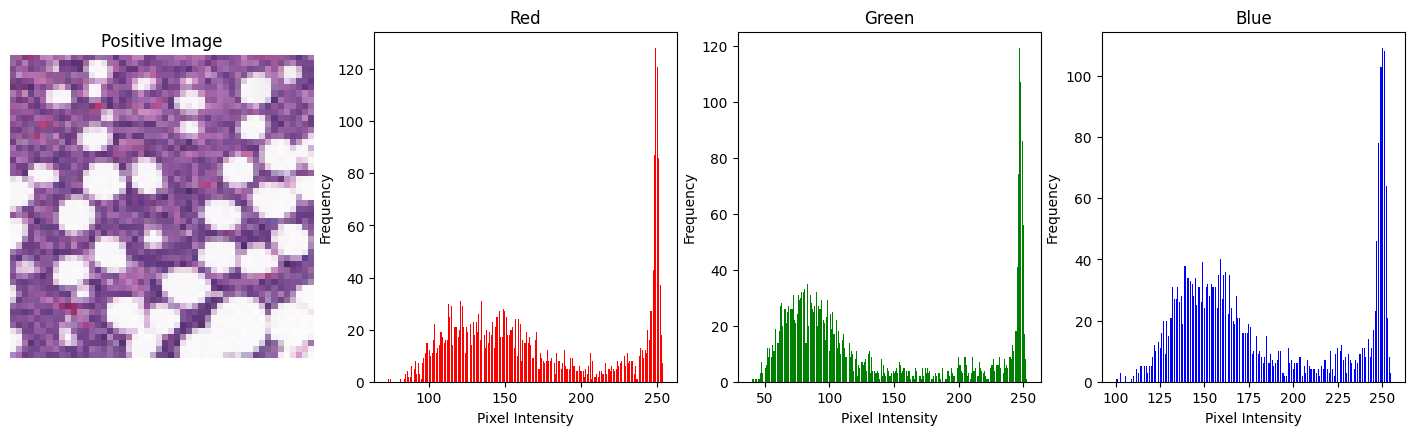

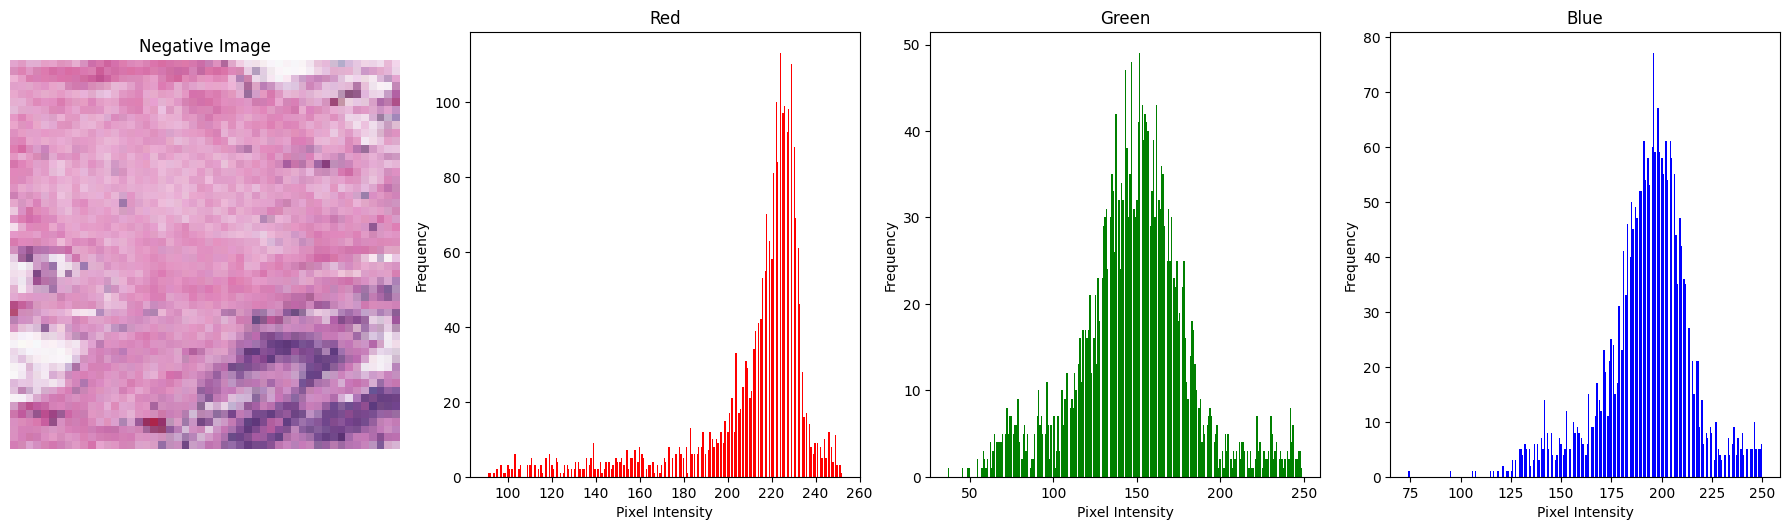

In [ ]:
def rgb_graph(image, title):
    red_channel = image[:, :, 0]
    green_channel = image[:, :, 1]
    blue_channel = image[:, :, 2]

    plt.figure(figsize=(18, 10))

    plt.subplot(2, 4, 1)
    plt.imshow(image)
    plt.title(title)
    plt.axis('off')

    plt.subplot(2, 4, 2)
    plt.hist(red_channel.ravel(), bins=256, color='red')
    plt.title('Red')
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency')

    plt.subplot(2, 4, 3)
    plt.hist(green_channel.ravel(), bins=256, color='green')
    plt.title('Green')
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency')

    plt.subplot(2, 4, 4)
    plt.hist(blue_channel.ravel(), bins=256, color='blue')
    plt.title('Blue')
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency')

# Example usage with a positive image
positive_sample = positive_cases[4]  # Replace with your positive sample image
rgb_graph(positive_sample, 'Positive Image')

# Example usage with a negative image
negative_sample = negative_cases[0]  # Replace with your negative sample image
rgb_graph(negative_sample, 'Negative Image')

plt.tight_layout()
plt.show()

**Color Dominance** k-means clustering is used to find out dominant colors,RGB value (145,92,156) which looks like dark purple is dominant in positive case images and RGB value (207,116,170) which looks like light pink is dominant in the negative sample image. This suggests that there are some explainable differences in the images within the positive and negative cases.

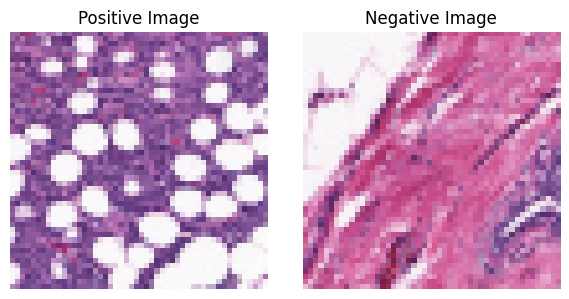

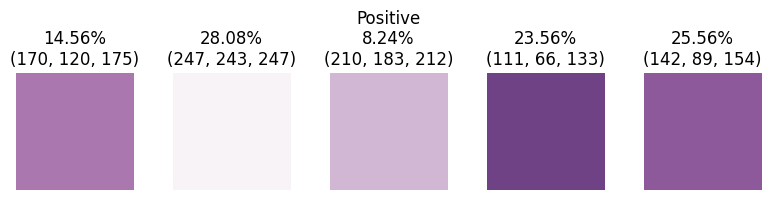

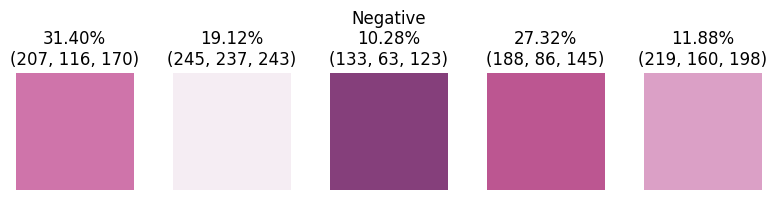

In [ ]:
def q_kmean(image, k=5):
    data = image.reshape((-1, 3))
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(data)
    centers = kmeans.cluster_centers_
    labels = kmeans.labels_

    q_image = centers[labels].reshape(image.shape).astype(np.uint8)

    # Calculate dominance
    unique, counts = np.unique(labels, return_counts=True)
    total_count = np.sum(counts)
    dominance = counts / total_count

    return q_image, centers, dominance

positive_sample = positive_cases[4]
negative_sample = negative_cases[5]

quantized_positive, positive_dom_color, positive_dom = q_kmean(positive_sample, k=5)
quantized_negative, dominant_colors_negative, dominance_negative = q_kmean(negative_sample, k=5)

plt.figure(figsize=(6, 3))

plt.subplot(1, 2, 1)
plt.imshow(positive_sample)
plt.title('Positive Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(negative_sample)
plt.title('Negative Image')
plt.axis('off')

plt.tight_layout()
plt.show()

def color_graph(dominant_colors, dominance, title):
    plt.figure(figsize=(8, 2))
    for i, (color, percent) in enumerate(zip(dominant_colors, dominance)):
        plt.subplot(1, len(dominant_colors), i + 1)
        rgb_value = tuple(color.astype(int))
        plt.imshow([[color.astype(int)]])
        plt.title(f'{percent*100:.2f}%\n{rgb_value}')
        plt.axis('off')
    plt.suptitle(title)
    plt.tight_layout()

    plt.show()

color_graph(positive_dom_color, positive_dom, 'Positive')
color_graph(dominant_colors_negative, dominance_negative, 'Negative')

**RATIONALE**: We can see from the above EDA analysis that the dataset is balanced and techniques like SMOTE, ROSE or class-weights are not required for the model.
Through RGB intensity graph we can see that there are outliers in both positive and negative case images. So, it might imply that the images might require normalization or standardization.

But normalization or standardization removes the importance of color variations within the images. Also, this is a medical imaging dataset and the presence of specific colors are important for model performance. Considering all the above factors we can come into a rationale that the model building architecture is straightforward without any normalization or standardization. But, the number of samples in the dataset is quite less, to compensate this we can deploy data augmentation strategies like rotation and flipping.


---

---





For efficient storage and processing we are storing the images as HDF5 files.


In [ ]:
with h5py.File('train_data.h5', 'w') as hf:
    hf.create_dataset('images', data=train_images)
    hf.create_dataset('labels', data=train_labels)

with h5py.File('val_data.h5', 'w') as hf:
    hf.create_dataset('images', data=val_images)
    hf.create_dataset('labels', data=val_labels)

with h5py.File('test_data.h5', 'w') as hf:
    hf.create_dataset('images', data=test_images)
    hf.create_dataset('labels', data=test_labels)

# Load data from HDF5 files
def load_hdf5_data(file_path):
    with h5py.File(file_path, 'r') as hf:
        images = hf['images'][:]
        labels = hf['labels'][:]
    return images, labels

train_images, train_labels = load_hdf5_data('train_data.h5')
val_images, val_labels = load_hdf5_data('val_data.h5')
test_images, test_labels = load_hdf5_data('test_data.h5')

print(f"Train images shape: {train_images.shape}")
print(f"Train labels shape: {train_labels.shape}")

print(f"Validation images shape: {val_images.shape}")
print(f"Validation labels shape: {val_labels.shape}")

print(f"Test images shape: {test_images.shape}")
print(f"Test labels shape: {test_labels.shape}")

Train images shape: (3882, 50, 50, 3)
Train labels shape: (3882,)
Validation images shape: (832, 50, 50, 3)
Validation labels shape: (832,)
Test images shape: (833, 50, 50, 3)
Test labels shape: (833,)


**Data Augmentation**
Using Keras ImageDataGenerator function, the images are augmented by random rotation, horizontal flipping and vertical flipping. Four different types of images are generated for every single image. Since the dataset is medical imaging, to preserve the essence of the images we do not use any other augmentation techniques. From 3882 images, after augmentation the size got increased to 15528 images.

In [ ]:
image_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=135,
    horizontal_flip=True,
    vertical_flip=True
)

augmented_images = []
augmented_labels = []

for i in range(len(train_images)):
    img = train_images[i].reshape((1,) + train_images[i].shape)
    label = train_labels[i]

    count = 0
    for batch in image_gen.flow(img, batch_size=1):
        augmented_images.append(batch[0].astype('uint8'))
        augmented_labels.append(label)
        count += 1
        if count >= 4:
            break

augmented_images = np.array(augmented_images)
augmented_labels = np.array(augmented_labels)

print("Augmented images shape:", augmented_images.shape)
print("Augmented labels shape:", augmented_labels.shape)

Augmented images shape: (15528, 50, 50, 3)
Augmented labels shape: (15528,)


The augmentation is done perfectly without any errors, rotation and flips are used efficiently to augment the images.  For efficient storage, the augmented data is then stored in hd5 format.

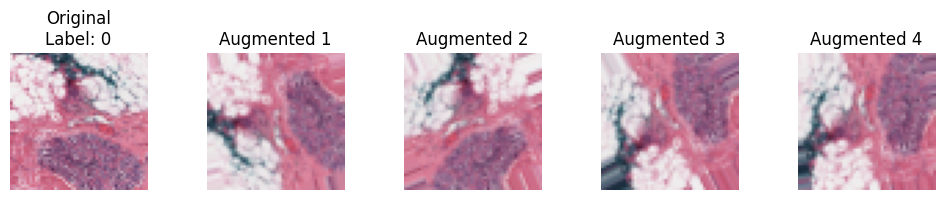

Augmented images shape: (15528, 50, 50, 3)
Augmented labels shape: (15528,)


In [ ]:

def aug_plot(original_image, original_label, augmented_images, aug_count=4):
    plt.figure(figsize=(10, 2))

    plt.subplot(1, aug_count + 1, 1)
    plt.imshow(original_image)
    plt.title(f'Original\nLabel: {original_label}')
    plt.axis('off')

    for count_augs in range(aug_count):
        plt.subplot(1, aug_count + 1, count_augs + 2)
        plt.imshow(augmented_images[count_augs])
        plt.title(f'Augmented {count_augs + 1}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Example usage for the 4th image (index 3)
aug_plot(train_images[3], train_labels[3], augmented_images[12:16])

def save_hdf5_data(file_path, images, labels):
    with h5py.File(file_path, 'w') as hf:
        hf.create_dataset('images', data=images)
        hf.create_dataset('labels', data=labels)

save_hdf5_data('augmented_data.h5', augmented_images, augmented_labels)

**MODEL RATIONALE**

---



**CNN-LSTM**
CNN are well known for identifying spatial features in images like edges, shapes and textures and LSTM can identify temporal dependencies, combining both can give good performance.

**CNN**
CNN are good at finding spatial hierarchies, pooling function helps in handling complex datasets. CNN are known to perform better in image visualization, their inbuilt filters can help in accessing the essential information from images.

**Vanilla ANN**
ANN forms the basic level of architecture and they are highly easy to train with few parameters. They are also computationally efficient.

**LSTM**
LSTM are versatile in nature and are efficient in handling past information and temporal dependencies.

**Random Forest**
Random forest is one of the most popular ensemble algorithms, the combination of multiple decision trees helps in reducing the possibility of overfitting.

**KNN (K-Nearest Neighbors)**
KNN classifiers are easy to train and evaluate. They can handle complex datasets with ease and are highly efficient in classifying multi-class datasets.

**Naive Bayes**
Naive Bayes are inherently robust in nature, they are also computationally efficient. Training and evaluation of the metrics is easier and the models can handle high dimensional datasets efficiently.


**MODELS**

---



---


**CNN-LSTM**

---



**CNN-LSTM Model Building**
For reproducibility seed is set to 1, Keras sequential function is used to initiate the layers. The model consists of 2 convolution blocks with 32 and 64 filters respectively and with activation functions relu and elu respectively. MaxPooling is done using a 2*2 pool size.
To improve model efficiency after each convolution blocks batch normalization is implemented. To improve regularization and to prevent overfitting a dropout of 0.25 is implemented. The output is flattened and reshaped before passing it to the LSTM layer. The output of LSTM is passed to a dense layer with 1 neuron to determine the output. Sigmoid activation is used for the dense output. Since the problem is binary classification, binary_crossentropy is used as the loss function.


In [ ]:
def cnn_lstm(units, optimizer, learning_rate):
      set_seed(1)
      optimizers_dict = {
            'adam': Adam,
            'sgd': SGD,
          'rmsprop': RMSprop,
          'Adagrad': Adagrad
        }
      cnn_lstm_model = Sequential()
      cnn_lstm_model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(50, 50, 3)))
      cnn_lstm_model.add(BatchNormalization())
      cnn_lstm_model.add(MaxPooling2D((2, 2)))
      cnn_lstm_model.add(Dropout(0.25))
      cnn_lstm_model.add(Conv2D(64, (3, 3), activation='elu', padding='same'))
      cnn_lstm_model.add(BatchNormalization())
      cnn_lstm_model.add(MaxPooling2D((2, 2)))
      cnn_lstm_model.add(Dropout(0.25))
      cnn_lstm_model.add(Flatten())
      cnn_lstm_model.add(Reshape((-1, cnn_lstm_model.output_shape[-1])))

      #lstm
      cnn_lstm_model.add(LSTM(units))
     # Output layer for binary classification
      cnn_lstm_model.add(Dense(1, activation='sigmoid'))
      optimizer_class = optimizers_dict[optimizer]
      optimizer = optimizer_class(learning_rate=learning_rate)
      cnn_lstm_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
      return cnn_lstm_model

**CNN_LSTM Hyperparameter tuning**
KerasClassifier and GridSearchCV function is used for hyperparameter tuning. Epochs is set to 5, LSTM model unit is set to 100, 'adam','rmsprop','sgd' and 'Adagrad' optimizers are checked with 0.001 and 0.00001 learning rates. 2-fold cross validation is used.


In [ ]:
cnn_lstm_tune = KerasClassifier(build_fn=cnn_lstm, verbose=1)

params={
    'epochs':[5],
    'model__units':[100],
    'model__optimizer':['adam','rmsprop','sgd','Adagrad'],
    'model__learning_rate':[0.0001,0.00001],
    }

search=GridSearchCV(estimator=cnn_lstm_tune, param_grid=params, cv=2, verbose=3)
search = search.fit(augmented_images, augmented_labels)

parameters_cnnlstm = search.best_params_
print("parameters: ", parameters_cnnlstm)

Fitting 2 folds for each of 8 candidates, totalling 16 fits


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
243/243 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.7174 - loss: 0.5742
Epoch 2/5
243/243 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7609 - loss: 0.5150
Epoch 3/5
243/243 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7702 - loss: 0.5000
Epoch 4/5
243/243 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7753 - loss: 0.4857
Epoch 5/5
243/243 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7901 - loss: 0.4706
243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
[CV 1/2] END epochs=5, model__learning_rate=0.0001, model__optimizer=adam, model__units=100;, score=0.772 total time=  13.0s


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
243/243 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.7226 - loss: 0.5565
Epoch 2/5
243/243 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7759 - loss: 0.4933
Epoch 3/5
243/243 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7852 - loss: 0.4833
Epoch 4/5
243/243 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7862 - loss: 0.4714
Epoch 5/5
243/243 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7909 - loss: 0.4606
243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
[CV 2/2] END epochs=5, model__learning_rate=0.0001, model__optimizer=adam, model__units=100;, score=0.762 total time=  12.3s


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
243/243 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.7079 - loss: 0.5700
Epoch 2/5
243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7639 - loss: 0.5091
Epoch 3/5
243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7714 - loss: 0.4972
Epoch 4/5
243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7793 - loss: 0.4818
Epoch 5/5
243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7821 - loss: 0.4726
243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
[CV 1/2] END epochs=5, model__learning_rate=0.0001, model__optimizer=rmsprop, model__units=100;, score=0.773 total time=  10.0s


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
243/243 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.7276 - loss: 0.5546
Epoch 2/5
243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7786 - loss: 0.4944
Epoch 3/5
243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7814 - loss: 0.4852
Epoch 4/5
243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7849 - loss: 0.4777
Epoch 5/5
243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7875 - loss: 0.4639
243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
[CV 2/2] END epochs=5, model__learning_rate=0.0001, model__optimizer=rmsprop, model__units=100;, score=0.769 total time=  10.0s


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
243/243 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5181 - loss: 0.7011
Epoch 2/5
243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6065 - loss: 0.6623
Epoch 3/5
243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6426 - loss: 0.6414
Epoch 4/5
243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6672 - loss: 0.6256
Epoch 5/5
243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6757 - loss: 0.6161
243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
[CV 1/2] END epochs=5, model__learning_rate=0.0001, model__optimizer=sgd, model__units=100;, score=0.699 total time=   8.4s


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
243/243 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5106 - loss: 0.7019
Epoch 2/5
243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6314 - loss: 0.6521
Epoch 3/5
243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6692 - loss: 0.6310
Epoch 4/5
243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6825 - loss: 0.6141
Epoch 5/5
243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6942 - loss: 0.6033
243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
[CV 2/2] END epochs=5, model__learning_rate=0.0001, model__optimizer=sgd, model__units=100;, score=0.699 total time=   8.3s


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
243/243 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5551 - loss: 0.6844
Epoch 2/5
243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6693 - loss: 0.6242
Epoch 3/5
243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6825 - loss: 0.6034
Epoch 4/5
243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6917 - loss: 0.5922
Epoch 5/5
243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7025 - loss: 0.5864
243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
[CV 1/2] END epochs=5, model__learning_rate=0.0001, model__optimizer=Adagrad, model__units=100;, score=0.718 total time=   9.6s


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
243/243 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5587 - loss: 0.6836
Epoch 2/5
243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6871 - loss: 0.6086
Epoch 3/5
243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7091 - loss: 0.5885
Epoch 4/5
243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7157 - loss: 0.5734
Epoch 5/5
243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7216 - loss: 0.5670
243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
[CV 2/2] END epochs=5, model__learning_rate=0.0001, model__optimizer=Adagrad, model__units=100;, score=0.718 total time=  10.0s


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
243/243 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.6480 - loss: 0.6245
Epoch 2/5
243/243 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7315 - loss: 0.5558
Epoch 3/5
243/243 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7498 - loss: 0.5343
Epoch 4/5
243/243 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7549 - loss: 0.5232
Epoch 5/5
243/243 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7606 - loss: 0.5175
243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
[CV 1/2] END epochs=5, model__learning_rate=1e-05, model__optimizer=adam, model__units=100;, score=0.765 total time=  12.1s


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
243/243 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.6711 - loss: 0.6181
Epoch 2/5
243/243 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7467 - loss: 0.5275
Epoch 3/5
243/243 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7648 - loss: 0.5105
Epoch 4/5
243/243 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7663 - loss: 0.5031
Epoch 5/5
243/243 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7714 - loss: 0.4968
243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
[CV 2/2] END epochs=5, model__learning_rate=1e-05, model__optimizer=adam, model__units=100;, score=0.761 total time=  11.9s


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
243/243 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.6551 - loss: 0.6201
Epoch 2/5
243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7293 - loss: 0.5574
Epoch 3/5
243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7465 - loss: 0.5369
Epoch 4/5
243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7558 - loss: 0.5254
Epoch 5/5
243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7592 - loss: 0.5200
243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
[CV 1/2] END epochs=5, model__learning_rate=1e-05, model__optimizer=rmsprop, model__units=100;, score=0.763 total time=  10.0s


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
243/243 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.6775 - loss: 0.6131
Epoch 2/5
243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7462 - loss: 0.5293
Epoch 3/5
243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7644 - loss: 0.5132
Epoch 4/5
243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7659 - loss: 0.5049
Epoch 5/5
243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7676 - loss: 0.4994
243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
[CV 2/2] END epochs=5, model__learning_rate=1e-05, model__optimizer=rmsprop, model__units=100;, score=0.761 total time=   9.8s


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
243/243 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.4792 - loss: 0.7149
Epoch 2/5
243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4926 - loss: 0.7086
Epoch 3/5
243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5030 - loss: 0.7047
Epoch 4/5
243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5282 - loss: 0.6971
Epoch 5/5
243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5304 - loss: 0.6942
243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
[CV 1/2] END epochs=5, model__learning_rate=1e-05, model__optimizer=sgd, model__units=100;, score=0.578 total time=   8.9s


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
243/243 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.4734 - loss: 0.7175
Epoch 2/5
243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4994 - loss: 0.7047
Epoch 3/5
243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5109 - loss: 0.7008
Epoch 4/5
243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5351 - loss: 0.6939
Epoch 5/5
243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5418 - loss: 0.6887
243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
[CV 2/2] END epochs=5, model__learning_rate=1e-05, model__optimizer=sgd, model__units=100;, score=0.581 total time=   8.5s


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
243/243 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.4870 - loss: 0.7124
Epoch 2/5
243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5196 - loss: 0.6990
Epoch 3/5
243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5447 - loss: 0.6890
Epoch 4/5
243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5716 - loss: 0.6777
Epoch 5/5
243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5863 - loss: 0.6726
243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
[CV 1/2] END epochs=5, model__learning_rate=1e-05, model__optimizer=Adagrad, model__units=100;, score=0.655 total time=   9.6s


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
243/243 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.4787 - loss: 0.7148
Epoch 2/5
243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5238 - loss: 0.6945
Epoch 3/5
243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5475 - loss: 0.6850
Epoch 4/5
243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5838 - loss: 0.6732
Epoch 5/5
243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6021 - loss: 0.6662
243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
[CV 2/2] END epochs=5, model__learning_rate=1e-05, model__optimizer=Adagrad, model__units=100;, score=0.657 total time=   9.5s


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
486/486 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.7359 - loss: 0.5474
Epoch 2/5
486/486 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7659 - loss: 0.5017
Epoch 3/5
486/486 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.7727 - loss: 0.4895
Epoch 4/5
486/486 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.7760 - loss: 0.4792
Epoch 5/5
486/486 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.7836 - loss: 0.4705
parameters:  {'epochs': 5, 'model__learning_rate': 0.0001, 'model__optimizer': 'rmsprop', 'model__units': 100}


**Model Training**
Model is fit and trained using the best parameters with 15 epochs and also validation is used to check for overfitting.

In [ ]:
cnn_lstm_model_trained = cnn_lstm(units=100, optimizer='rmsprop', learning_rate= 0.0001)
cnn_lstm_model_trained.fit(augmented_images, augmented_labels, epochs=15, verbose=1,validation_data=(val_images, val_labels), batch_size=32)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
486/486 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.7362 - loss: 0.5474 - val_accuracy: 0.7019 - val_loss: 0.6459
Epoch 2/15
486/486 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.7657 - loss: 0.5021 - val_accuracy: 0.7464 - val_loss: 0.5357
Epoch 3/15
486/486 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.7681 - loss: 0.4910 - val_accuracy: 0.7476 - val_loss: 0.5299
Epoch 4/15
486/486 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.7815 - loss: 0.4796 - val_accuracy: 0.7464 - val_loss: 0.5273
Epoch 5/15
486/486 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.7816 - loss: 0.4708 - val_accuracy: 0.7476 - val_loss: 0.5367
Epoch 6/15
486/486 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.7902 - loss: 0.4610 - val_accuracy: 0.7608 - val_loss: 0.5051
Epoch 7/15
486/486 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.7958 - loss: 0.4501 - val_accuracy: 0.7608 - val_loss: 0.5039
Epoch 8/15
486/486 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8041 - loss: 0.4400 - val_accuracy: 0.

**Model Evaluation**
Evaluating the cnn-lstm model with test dataset gave an accuracy of 0.7179

In [ ]:
test_loss, test_accuracy = cnn_lstm_model_trained.evaluate(test_images, test_labels, verbose=1)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7148 - loss: 0.6063
Test Loss: 0.6054224371910095
Test Accuracy: 0.7178871631622314


**Model Performance**
The model performances is good with overall accuracy of 72%, the precision and recall are higher for negative class, compared to the positive class. Both AUROC and AUPRC scores are high indicating model can classify both positive and negative classes effectively. F1 score of 0.71 also shows that the model is balanced with respect to precision and recall.

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


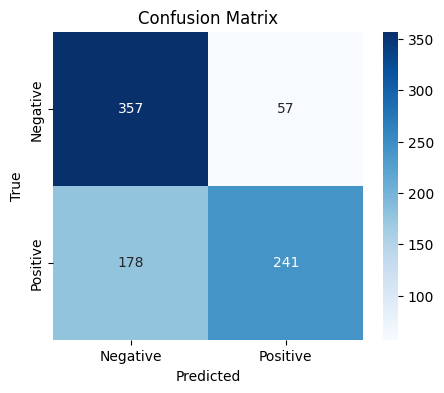

Report:
              precision    recall  f1-score   support

    Negative       0.67      0.86      0.75       414
    Positive       0.81      0.58      0.67       419

    accuracy                           0.72       833
   macro avg       0.74      0.72      0.71       833
weighted avg       0.74      0.72      0.71       833

ROC AUC Score: 0.8156468702800549


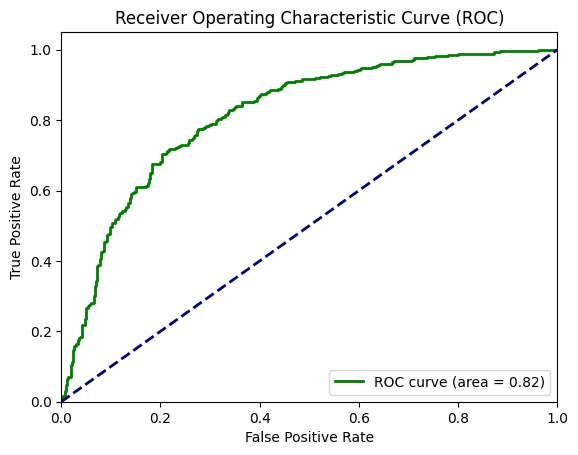

PR AUC Score: 0.7812125362916396


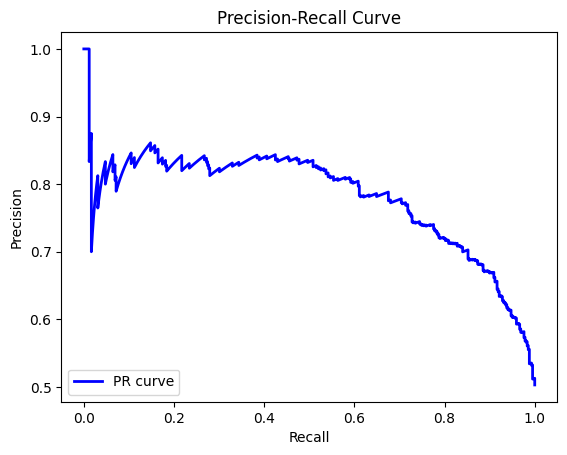

In [ ]:
predictions_cnn_lstm = cnn_lstm_model_trained.predict(test_images)
predicted_classes_cnn_lstm = (predictions_cnn_lstm > 0.5).astype("int32")
true_classes_cnn_lstm = test_labels.astype("int32")
conf_matrix = confusion_matrix(true_classes_cnn_lstm, predicted_classes_cnn_lstm)
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print("Report:")
print(classification_report(true_classes_cnn_lstm, predicted_classes_cnn_lstm, target_names=['Negative', 'Positive']))

#ROC
roc_auc = roc_auc_score(true_classes_cnn_lstm, predictions_cnn_lstm)
print(f"ROC AUC Score: {roc_auc}")
f_p_r, t_p_r, thresholds = roc_curve(true_classes_cnn_lstm, predictions_cnn_lstm)
plt.figure()
plt.plot(f_p_r, t_p_r, color='green', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve (ROC)')
plt.legend(loc="lower right")
plt.show()

#PRC
precision_vals, recall_vals, _ = precision_recall_curve(true_classes_cnn_lstm, predictions_cnn_lstm)
pr_auc = auc(recall_vals, precision_vals)
print(f"PR AUC Score: {pr_auc}")
plt.figure()
plt.plot(recall_vals, precision_vals, color='blue', lw=2, label='PR curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()

**CNN**
The model consists of two convolution blocks with batch normalization and dropout implemented. The maxpooling is given a pool size of 2,2 and the output is flattened before passing to the dense layer. Relu and elu activation function is used for convolution blocks and for dense layer with 1 neuron sigmoid activation is used. Loss function is set to binary_crossentropy


In [ ]:
def create_cnn_model(optimizer, learning_rate):
    set_seed(42)
    optimizers_dict = {
          'adam': Adam,
          'sgd': SGD,
          'rmsprop': RMSprop,
          'Adagrad': Adagrad
        }
    model_cnn = Sequential()
    # convolutional layer
    model_cnn.add(Conv2D(32, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu', input_shape=(50, 50, 3)))
    model_cnn.add(BatchNormalization())
    model_cnn.add(MaxPooling2D(pool_size=(2,2)))
    model_cnn.add(Dropout(0.5))
    model_cnn.add(Conv2D(64, (3, 3), activation='elu', padding='same'))
    model_cnn.add(BatchNormalization())
    model_cnn.add(MaxPooling2D((2, 2)))
    model_cnn.add(Dropout(0.5))
    model_cnn.add(Flatten())
    model_cnn.add(Dense(1, activation='sigmoid'))
    optimizer_class = optimizers_dict[optimizer]
    optimizer = optimizer_class(learning_rate=learning_rate)
    # compiling the sequential model
    model_cnn.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer=optimizer)
    return model_cnn

**CNN Hyperparameter tuning**
GridSearchCV with KerasClassifier is used for tuning, best parameters for optimizer and learning rate is searched.


In [ ]:
model_cnn_tune = KerasClassifier(build_fn=create_cnn_model, verbose=1)
params={
    'epochs':[5],
    'model__optimizer':['adam','rmsprop','sgd','Adagrad'],
    'model__learning_rate':[0.0001,0.00001],
    }
search=GridSearchCV(estimator=model_cnn_tune, param_grid=params, cv=2, verbose=3)
search = search.fit(augmented_images, augmented_labels)
best_params_cnn = search.best_params_
print("Best Parameters: ", best_params_cnn)

Fitting 2 folds for each of 8 candidates, totalling 16 fits


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
243/243 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.6132 - loss: 0.9229
Epoch 2/5
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6679 - loss: 0.7876
Epoch 3/5
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6882 - loss: 0.7373
Epoch 4/5
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6963 - loss: 0.6687
Epoch 5/5
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7019 - loss: 0.6445
243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
[CV 1/2] END epochs=5, model__learning_rate=0.0001, model__optimizer=adam;, score=0.594 total time=  14.0s


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
243/243 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - accuracy: 0.6137 - loss: 0.9356
Epoch 2/5
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6775 - loss: 0.7833
Epoch 3/5
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6971 - loss: 0.7118
Epoch 4/5
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7166 - loss: 0.6789
Epoch 5/5
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7243 - loss: 0.6383
243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
[CV 2/2] END epochs=5, model__learning_rate=0.0001, model__optimizer=adam;, score=0.756 total time=  11.4s


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
243/243 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - accuracy: 0.6210 - loss: 0.9207
Epoch 2/5
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6709 - loss: 0.7895
Epoch 3/5
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6763 - loss: 0.7461
Epoch 4/5
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6915 - loss: 0.6807
Epoch 5/5
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7063 - loss: 0.6377
243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
[CV 1/2] END epochs=5, model__learning_rate=0.0001, model__optimizer=rmsprop;, score=0.523 total time=  12.3s


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
243/243 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.6068 - loss: 0.9290
Epoch 2/5
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6764 - loss: 0.7793
Epoch 3/5
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6999 - loss: 0.7101
Epoch 4/5
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7133 - loss: 0.6715
Epoch 5/5
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7246 - loss: 0.6333
243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
[CV 2/2] END epochs=5, model__learning_rate=0.0001, model__optimizer=rmsprop;, score=0.754 total time=  10.5s


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
243/243 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - accuracy: 0.5659 - loss: 1.0146
Epoch 2/5
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6166 - loss: 0.9049
Epoch 3/5
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6354 - loss: 0.8849
Epoch 4/5
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6457 - loss: 0.8464
Epoch 5/5
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6480 - loss: 0.8322
243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
[CV 1/2] END epochs=5, model__learning_rate=0.0001, model__optimizer=sgd;, score=0.736 total time=  10.9s


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
243/243 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.5524 - loss: 1.0222
Epoch 2/5
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6184 - loss: 0.8834
Epoch 3/5
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6416 - loss: 0.8374
Epoch 4/5
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6546 - loss: 0.8291
Epoch 5/5
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6603 - loss: 0.8019
243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
[CV 2/2] END epochs=5, model__learning_rate=0.0001, model__optimizer=sgd;, score=0.728 total time=   9.8s
Epoch 1/5


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


243/243 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - accuracy: 0.5641 - loss: 1.0122
Epoch 2/5
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6002 - loss: 0.9417
Epoch 3/5
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6114 - loss: 0.9403
Epoch 4/5
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6215 - loss: 0.9107
Epoch 5/5
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6239 - loss: 0.9060
243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
[CV 1/2] END epochs=5, model__learning_rate=0.0001, model__optimizer=Adagrad;, score=0.724 total time=  11.7s


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
243/243 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.5525 - loss: 1.0164
Epoch 2/5
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6011 - loss: 0.9228
Epoch 3/5
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6138 - loss: 0.9010
Epoch 4/5
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6236 - loss: 0.9083
Epoch 5/5
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6324 - loss: 0.8853
243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
[CV 2/2] END epochs=5, model__learning_rate=0.0001, model__optimizer=Adagrad;, score=0.710 total time=  10.5s


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
243/243 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.5528 - loss: 1.0501
Epoch 2/5
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6022 - loss: 0.9401
Epoch 3/5
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6226 - loss: 0.9223
Epoch 4/5
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6368 - loss: 0.8810
Epoch 5/5
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6425 - loss: 0.8688
243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
[CV 1/2] END epochs=5, model__learning_rate=1e-05, model__optimizer=adam;, score=0.740 total time=  11.7s


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
243/243 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - accuracy: 0.5436 - loss: 1.0566
Epoch 2/5
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6026 - loss: 0.9204
Epoch 3/5
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6259 - loss: 0.8807
Epoch 4/5
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6434 - loss: 0.8768
Epoch 5/5
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6530 - loss: 0.8470
243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
[CV 2/2] END epochs=5, model__learning_rate=1e-05, model__optimizer=adam;, score=0.725 total time=  11.5s


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
243/243 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.5523 - loss: 1.0391
Epoch 2/5
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6009 - loss: 0.9392
Epoch 3/5
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6246 - loss: 0.9242
Epoch 4/5
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6383 - loss: 0.8831
Epoch 5/5
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6397 - loss: 0.8717
243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
[CV 1/2] END epochs=5, model__learning_rate=1e-05, model__optimizer=rmsprop;, score=0.738 total time=  10.7s
Epoch 1/5


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


243/243 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.5447 - loss: 1.0450
Epoch 2/5
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6044 - loss: 0.9174
Epoch 3/5
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6299 - loss: 0.8804
Epoch 4/5
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6455 - loss: 0.8766
Epoch 5/5
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6569 - loss: 0.8477
243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
[CV 2/2] END epochs=5, model__learning_rate=1e-05, model__optimizer=rmsprop;, score=0.721 total time=  10.5s


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
243/243 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.5314 - loss: 1.1195
Epoch 2/5
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5475 - loss: 1.0427
Epoch 3/5
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5666 - loss: 1.0263
Epoch 4/5
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5716 - loss: 0.9943
Epoch 5/5
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5715 - loss: 0.9773
243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
[CV 1/2] END epochs=5, model__learning_rate=1e-05, model__optimizer=sgd;, score=0.661 total time=   9.8s


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
243/243 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - accuracy: 0.5306 - loss: 1.1216
Epoch 2/5
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5509 - loss: 1.0135
Epoch 3/5
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5658 - loss: 0.9919
Epoch 4/5
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5683 - loss: 0.9883
Epoch 5/5
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5910 - loss: 0.9577
243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
[CV 2/2] END epochs=5, model__learning_rate=1e-05, model__optimizer=sgd;, score=0.661 total time=  10.7s
Epoch 1/5


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


243/243 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.5311 - loss: 1.1484
Epoch 2/5
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5367 - loss: 1.0875
Epoch 3/5
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5439 - loss: 1.0830
Epoch 4/5
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5435 - loss: 1.0599
Epoch 5/5
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5363 - loss: 1.0548
243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
[CV 1/2] END epochs=5, model__learning_rate=1e-05, model__optimizer=Adagrad;, score=0.617 total time=  10.4s


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
243/243 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.5261 - loss: 1.1506
Epoch 2/5
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5386 - loss: 1.0532
Epoch 3/5
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5514 - loss: 1.0481
Epoch 4/5
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5417 - loss: 1.0555
Epoch 5/5
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5527 - loss: 1.0455
243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
[CV 2/2] END epochs=5, model__learning_rate=1e-05, model__optimizer=Adagrad;, score=0.613 total time=  10.4s


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
486/486 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.5695 - loss: 1.0338
Epoch 2/5
486/486 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6272 - loss: 0.8836
Epoch 3/5
486/486 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6481 - loss: 0.8584
Epoch 4/5
486/486 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6579 - loss: 0.8068
Epoch 5/5
486/486 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6725 - loss: 0.7991
Best Parameters:  {'epochs': 5, 'model__learning_rate': 1e-05, 'model__optimizer': 'adam'}


**CNN Model Training**
CNN model is training using the best parameters from tuning and also validation is used to check for overfitting.


In [ ]:
model_cnn = create_cnn_model(optimizer='adam', learning_rate= 1e-05)

model_cnn.fit(augmented_images, augmented_labels, epochs=20, verbose=1,validation_data=(val_images, val_labels), batch_size=32)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
486/486 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.5693 - loss: 1.0338 - val_accuracy: 0.6803 - val_loss: 0.6353
Epoch 2/20
486/486 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6272 - loss: 0.8835 - val_accuracy: 0.7055 - val_loss: 0.5944
Epoch 3/20
486/486 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6480 - loss: 0.8585 - val_accuracy: 0.7188 - val_loss: 0.5734
Epoch 4/20
486/486 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6573 - loss: 0.8068 - val_accuracy: 0.7356 - val_loss: 0.5648
Epoch 5/20
486/486 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6726 - loss: 0.7990 - val_accuracy: 0.7476 - val_loss: 0.5489
Epoch 6/20
486/486 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6782 - loss: 0.7674 - val_accuracy: 0.7536 - val_loss: 0.5416
Epoch 7/20
486/486 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6671 - loss: 0.7817 - val_accuracy: 0.7524 - val_loss: 0.5384
Epoch 8/20
486/486 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6761 - loss: 0.7648 - val_accuracy: 

**CNN Model Evaluation**
Accuracy of 64% is obtained with test dataset.


In [ ]:
test_loss, test_accuracy = model_cnn.evaluate(test_images, test_labels, verbose=1)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.6416 - loss: 0.7035
Test Loss: 0.7347134351730347
Test Accuracy: 0.6458583474159241


**CNN Model Performance**
Negative class precision is good, but recall values are bad this indicates that there are more false negatives. High ROC AUC and PR AUC suggests that the model is able to differentiate between the classes. F1 Score is leaning more towards the positive class, indicating model model performs better for positive class.


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


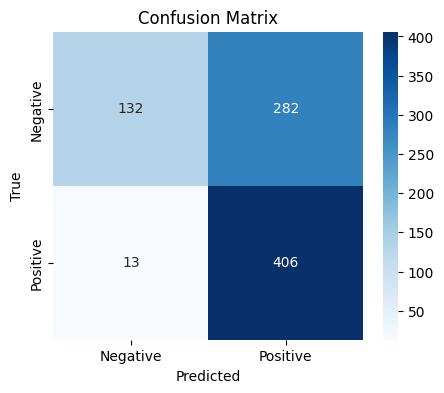

Report:
              precision    recall  f1-score   support

    Negative       0.91      0.32      0.47       414
    Positive       0.59      0.97      0.73       419

    accuracy                           0.65       833
   macro avg       0.75      0.64      0.60       833
weighted avg       0.75      0.65      0.60       833

ROC AUC Score: 0.8114327879815064


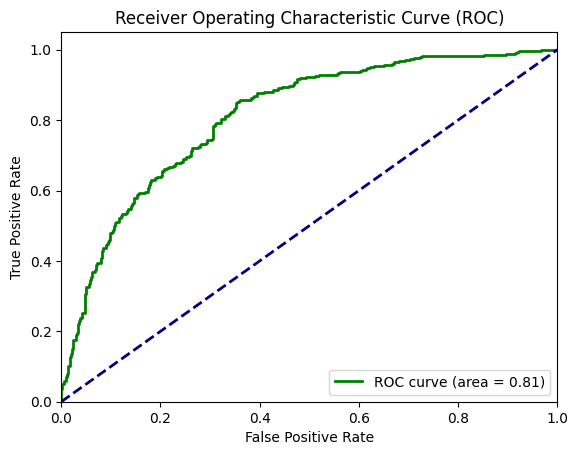

PR AUC Score: 0.7926561710142574


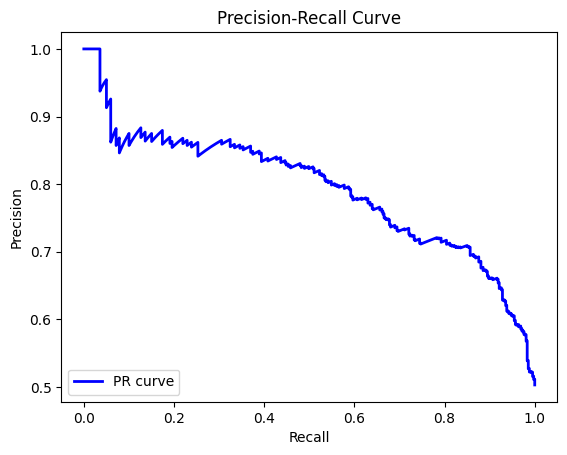

In [ ]:
predictions_cnn = model_cnn.predict(test_images)
predicted_classes_cnn = (predictions_cnn > 0.5).astype("int32")
true_classes_cnn = test_labels.astype("int32")
conf_matrix = confusion_matrix(true_classes_cnn, predicted_classes_cnn)
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print("Report:")
print(classification_report(true_classes_cnn, predicted_classes_cnn, target_names=['Negative', 'Positive']))


#ROC
roc_auc = roc_auc_score(true_classes_cnn, predictions_cnn)
print(f"ROC AUC Score: {roc_auc}")
f_p_r, t_p_r, thresholds = roc_curve(true_classes_cnn, predictions_cnn)
plt.figure()
plt.plot(f_p_r, t_p_r, color='green', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve (ROC)')
plt.legend(loc="lower right")
plt.show()

#PRC
precision_vals, recall_vals, _ = precision_recall_curve(true_classes_cnn, predictions_cnn)
pr_auc = auc(recall_vals, precision_vals)
print(f"PR AUC Score: {pr_auc}")
plt.figure()
plt.plot(recall_vals, precision_vals, color='blue', lw=2, label='PR curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()

**ANN**
Three layers with 300,150,150 neurons are used with batch normalization and dropout implemented. The activation function for all the layers is set to relu. Binary_crossentropy is used for loss function and the optimizer used is SGD.

In [ ]:
def create_model_nn(learning_rate=0.01):
    set_seed(42)
    model_nn = Sequential()
    model_nn.add(Input(shape=(50, 50, 3)))
    model_nn.add(Flatten())
    model_nn.add(Dense(units = 300, activation="relu"))
    model_nn.add(BatchNormalization())
    model_nn.add(Dropout(0.5))
    model_nn.add(Dense(units = 150, activation="relu"))
    model_nn.add(BatchNormalization())
    model_nn.add(Dropout(0.5))
    model_nn.add(Dense(units = 150, activation="relu"))
    model_nn.add(BatchNormalization())
    model_nn.add(Dropout(0.5))
    model_nn.add(Dense(units=1,activation="sigmoid"))
    optimizer = SGD(learning_rate=learning_rate)
    model_nn.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model_nn

**ANN Hyperparameter tuning**
KerasClassifier and GridSearchCV is used for tuning, the best learning rate is searched using the combination of 0.001, 0.01 and 0.1. 2-fold cross validation is used.


In [ ]:
model_nn_tune = KerasClassifier(build_fn=create_model_nn, epochs=20, batch_size=32, verbose=2)
params={
    'model__learning_rate':[0.001, 0.01, 0.1],
    }
search = GridSearchCV(estimator=model_nn_tune, param_grid=params, cv=2, scoring='accuracy')
best_model_nn = search.fit(augmented_images, augmented_labels)

# Summarize results
print("Best: %f using %s" % (best_model_nn.best_score_, best_model_nn.best_params_))

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/20
243/243 - 9s - 36ms/step - accuracy: 0.6033 - loss: 0.8371
Epoch 2/20
243/243 - 0s - 2ms/step - accuracy: 0.6508 - loss: 0.7503
Epoch 3/20
243/243 - 0s - 2ms/step - accuracy: 0.6628 - loss: 0.7369
Epoch 4/20
243/243 - 0s - 2ms/step - accuracy: 0.6640 - loss: 0.7152
Epoch 5/20
243/243 - 0s - 2ms/step - accuracy: 0.6860 - loss: 0.6813
Epoch 6/20
243/243 - 0s - 2ms/step - accuracy: 0.6878 - loss: 0.6696
Epoch 7/20
243/243 - 0s - 2ms/step - accuracy: 0.6963 - loss: 0.6462
Epoch 8/20
243/243 - 0s - 2ms/step - accuracy: 0.6976 - loss: 0.6404
Epoch 9/20
243/243 - 0s - 2ms/step - accuracy: 0.7062 - loss: 0.6315
Epoch 10/20
243/243 - 0s - 2ms/step - accuracy: 0.7169 - loss: 0.6175
Epoch 11/20
243/243 - 0s - 2ms/step - accuracy: 0.7138 - loss: 0.6054
Epoch 12/20
243/243 - 0s - 2ms/step - accuracy: 0.7120 - loss: 0.5977
Epoch 13/20
243/243 - 0s - 2ms/step - accuracy: 0.7124 - loss: 0.5992
Epoch 14/20
243/243 - 0s - 2ms/step - accuracy: 0.7177 - loss: 0.5877
Epoch 15/20
243/243 - 0s - 2

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/20
243/243 - 9s - 36ms/step - accuracy: 0.6027 - loss: 0.8592
Epoch 2/20
243/243 - 0s - 2ms/step - accuracy: 0.6618 - loss: 0.7396
Epoch 3/20
243/243 - 0s - 2ms/step - accuracy: 0.6763 - loss: 0.7168
Epoch 4/20
243/243 - 0s - 2ms/step - accuracy: 0.6801 - loss: 0.6909
Epoch 5/20
243/243 - 0s - 2ms/step - accuracy: 0.6949 - loss: 0.6623
Epoch 6/20
243/243 - 0s - 2ms/step - accuracy: 0.7043 - loss: 0.6564
Epoch 7/20
243/243 - 0s - 2ms/step - accuracy: 0.7081 - loss: 0.6343
Epoch 8/20
243/243 - 0s - 2ms/step - accuracy: 0.7081 - loss: 0.6368
Epoch 9/20
243/243 - 0s - 2ms/step - accuracy: 0.7138 - loss: 0.6203
Epoch 10/20
243/243 - 0s - 2ms/step - accuracy: 0.7168 - loss: 0.6115
Epoch 11/20
243/243 - 0s - 2ms/step - accuracy: 0.7209 - loss: 0.5990
Epoch 12/20
243/243 - 0s - 2ms/step - accuracy: 0.7239 - loss: 0.5868
Epoch 13/20
243/243 - 0s - 2ms/step - accuracy: 0.7224 - loss: 0.5917
Epoch 14/20
243/243 - 0s - 2ms/step - accuracy: 0.7246 - loss: 0.5816
Epoch 15/20
243/243 - 0s - 2

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/20
243/243 - 9s - 36ms/step - accuracy: 0.6544 - loss: 0.7201
Epoch 2/20
243/243 - 0s - 2ms/step - accuracy: 0.7022 - loss: 0.6095
Epoch 3/20
243/243 - 0s - 2ms/step - accuracy: 0.7242 - loss: 0.5716
Epoch 4/20
243/243 - 0s - 2ms/step - accuracy: 0.7324 - loss: 0.5553
Epoch 5/20
243/243 - 0s - 2ms/step - accuracy: 0.7465 - loss: 0.5439
Epoch 6/20
243/243 - 0s - 2ms/step - accuracy: 0.7439 - loss: 0.5403
Epoch 7/20
243/243 - 0s - 2ms/step - accuracy: 0.7509 - loss: 0.5369
Epoch 8/20
243/243 - 0s - 2ms/step - accuracy: 0.7495 - loss: 0.5316
Epoch 9/20
243/243 - 0s - 2ms/step - accuracy: 0.7527 - loss: 0.5346
Epoch 10/20
243/243 - 0s - 2ms/step - accuracy: 0.7536 - loss: 0.5264
Epoch 11/20
243/243 - 0s - 2ms/step - accuracy: 0.7548 - loss: 0.5239
Epoch 12/20
243/243 - 0s - 2ms/step - accuracy: 0.7561 - loss: 0.5258
Epoch 13/20
243/243 - 0s - 2ms/step - accuracy: 0.7563 - loss: 0.5258
Epoch 14/20
243/243 - 0s - 2ms/step - accuracy: 0.7558 - loss: 0.5267
Epoch 15/20
243/243 - 0s - 2

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/20
243/243 - 9s - 36ms/step - accuracy: 0.6561 - loss: 0.7109
Epoch 2/20
243/243 - 0s - 2ms/step - accuracy: 0.7161 - loss: 0.5929
Epoch 3/20
243/243 - 0s - 2ms/step - accuracy: 0.7412 - loss: 0.5567
Epoch 4/20
243/243 - 0s - 2ms/step - accuracy: 0.7470 - loss: 0.5501
Epoch 5/20
243/243 - 0s - 2ms/step - accuracy: 0.7501 - loss: 0.5296
Epoch 6/20
243/243 - 0s - 2ms/step - accuracy: 0.7546 - loss: 0.5322
Epoch 7/20
243/243 - 0s - 2ms/step - accuracy: 0.7593 - loss: 0.5250
Epoch 8/20
243/243 - 0s - 2ms/step - accuracy: 0.7572 - loss: 0.5234
Epoch 9/20
243/243 - 0s - 2ms/step - accuracy: 0.7647 - loss: 0.5228
Epoch 10/20
243/243 - 0s - 2ms/step - accuracy: 0.7586 - loss: 0.5157
Epoch 11/20
243/243 - 0s - 2ms/step - accuracy: 0.7622 - loss: 0.5159
Epoch 12/20
243/243 - 0s - 2ms/step - accuracy: 0.7616 - loss: 0.5080
Epoch 13/20
243/243 - 0s - 2ms/step - accuracy: 0.7634 - loss: 0.5171
Epoch 14/20
243/243 - 0s - 2ms/step - accuracy: 0.7675 - loss: 0.5082
Epoch 15/20
243/243 - 0s - 2

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/20
243/243 - 9s - 36ms/step - accuracy: 0.7011 - loss: 0.6279
Epoch 2/20
243/243 - 0s - 2ms/step - accuracy: 0.7143 - loss: 0.5923
Epoch 3/20
243/243 - 0s - 2ms/step - accuracy: 0.7204 - loss: 0.5808
Epoch 4/20
243/243 - 0s - 2ms/step - accuracy: 0.7210 - loss: 0.5758
Epoch 5/20
243/243 - 0s - 2ms/step - accuracy: 0.7361 - loss: 0.5701
Epoch 6/20
243/243 - 0s - 2ms/step - accuracy: 0.7331 - loss: 0.5687
Epoch 7/20
243/243 - 0s - 2ms/step - accuracy: 0.7358 - loss: 0.5583
Epoch 8/20
243/243 - 0s - 2ms/step - accuracy: 0.7460 - loss: 0.5562
Epoch 9/20
243/243 - 0s - 2ms/step - accuracy: 0.7383 - loss: 0.5600
Epoch 10/20
243/243 - 0s - 2ms/step - accuracy: 0.7433 - loss: 0.5557
Epoch 11/20
243/243 - 0s - 2ms/step - accuracy: 0.7387 - loss: 0.5583
Epoch 12/20
243/243 - 0s - 2ms/step - accuracy: 0.7477 - loss: 0.5485
Epoch 13/20
243/243 - 0s - 2ms/step - accuracy: 0.7456 - loss: 0.5538
Epoch 14/20
243/243 - 0s - 2ms/step - accuracy: 0.7385 - loss: 0.5623
Epoch 15/20
243/243 - 0s - 2

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/20
243/243 - 9s - 36ms/step - accuracy: 0.7030 - loss: 0.6223
Epoch 2/20
243/243 - 0s - 2ms/step - accuracy: 0.7335 - loss: 0.5776
Epoch 3/20
243/243 - 0s - 2ms/step - accuracy: 0.7331 - loss: 0.5676
Epoch 4/20
243/243 - 0s - 2ms/step - accuracy: 0.7383 - loss: 0.5594
Epoch 5/20
243/243 - 0s - 2ms/step - accuracy: 0.7445 - loss: 0.5563
Epoch 6/20
243/243 - 0s - 2ms/step - accuracy: 0.7416 - loss: 0.5554
Epoch 7/20
243/243 - 0s - 2ms/step - accuracy: 0.7450 - loss: 0.5510
Epoch 8/20
243/243 - 0s - 2ms/step - accuracy: 0.7463 - loss: 0.5513
Epoch 9/20
243/243 - 0s - 2ms/step - accuracy: 0.7320 - loss: 0.5687
Epoch 10/20
243/243 - 0s - 2ms/step - accuracy: 0.7432 - loss: 0.5595
Epoch 11/20
243/243 - 0s - 2ms/step - accuracy: 0.7454 - loss: 0.5526
Epoch 12/20
243/243 - 0s - 2ms/step - accuracy: 0.7549 - loss: 0.5468
Epoch 13/20
243/243 - 0s - 2ms/step - accuracy: 0.7508 - loss: 0.5453
Epoch 14/20
243/243 - 0s - 2ms/step - accuracy: 0.7540 - loss: 0.5390
Epoch 15/20
243/243 - 0s - 2

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/20
486/486 - 9s - 19ms/step - accuracy: 0.6180 - loss: 0.8100
Epoch 2/20
486/486 - 1s - 2ms/step - accuracy: 0.6663 - loss: 0.7139
Epoch 3/20
486/486 - 1s - 1ms/step - accuracy: 0.6851 - loss: 0.6690
Epoch 4/20
486/486 - 1s - 2ms/step - accuracy: 0.7017 - loss: 0.6427
Epoch 5/20
486/486 - 1s - 2ms/step - accuracy: 0.7083 - loss: 0.6182
Epoch 6/20
486/486 - 1s - 1ms/step - accuracy: 0.7164 - loss: 0.5991
Epoch 7/20
486/486 - 1s - 1ms/step - accuracy: 0.7219 - loss: 0.5909
Epoch 8/20
486/486 - 1s - 1ms/step - accuracy: 0.7280 - loss: 0.5799
Epoch 9/20
486/486 - 1s - 1ms/step - accuracy: 0.7309 - loss: 0.5732
Epoch 10/20
486/486 - 1s - 1ms/step - accuracy: 0.7315 - loss: 0.5631
Epoch 11/20
486/486 - 1s - 1ms/step - accuracy: 0.7422 - loss: 0.5517
Epoch 12/20
486/486 - 1s - 1ms/step - accuracy: 0.7388 - loss: 0.5515
Epoch 13/20
486/486 - 1s - 1ms/step - accuracy: 0.7414 - loss: 0.5444
Epoch 14/20
486/486 - 1s - 1ms/step - accuracy: 0.7490 - loss: 0.5414
Epoch 15/20
486/486 - 1s - 1

**ANN Training**
ANN model is fit with the learning rate of 0.001 and epoch is set to 20. Validation data is used to validate the training accuracy.


In [ ]:
tf.keras.backend.clear_session()
model_nn = create_model_nn(learning_rate=0.001)
history = model_nn.fit(augmented_images, augmented_labels, epochs=20, batch_size=32, verbose=2,
                        validation_data=(val_images, val_labels))

Epoch 1/20
486/486 - 10s - 21ms/step - accuracy: 0.6180 - loss: 0.8100 - val_accuracy: 0.6899 - val_loss: 0.6783
Epoch 2/20
486/486 - 1s - 2ms/step - accuracy: 0.6663 - loss: 0.7139 - val_accuracy: 0.7007 - val_loss: 0.6499
Epoch 3/20
486/486 - 1s - 2ms/step - accuracy: 0.6851 - loss: 0.6690 - val_accuracy: 0.5901 - val_loss: 1.6903
Epoch 4/20
486/486 - 1s - 2ms/step - accuracy: 0.7017 - loss: 0.6427 - val_accuracy: 0.7464 - val_loss: 0.7622
Epoch 5/20
486/486 - 1s - 2ms/step - accuracy: 0.7083 - loss: 0.6182 - val_accuracy: 0.7536 - val_loss: 0.8013
Epoch 6/20
486/486 - 1s - 2ms/step - accuracy: 0.7164 - loss: 0.5991 - val_accuracy: 0.7500 - val_loss: 0.8053
Epoch 7/20
486/486 - 1s - 2ms/step - accuracy: 0.7219 - loss: 0.5909 - val_accuracy: 0.7572 - val_loss: 0.8151
Epoch 8/20
486/486 - 1s - 2ms/step - accuracy: 0.7280 - loss: 0.5799 - val_accuracy: 0.7548 - val_loss: 0.8168
Epoch 9/20
486/486 - 1s - 2ms/step - accuracy: 0.7309 - loss: 0.5732 - val_accuracy: 0.7548 - val_loss: 0.8255

**ANN Evaluation**
74% accuracy is obtained with the test dataset.


In [ ]:
test_loss, test_accuracy = model_nn.evaluate(test_images, test_labels, verbose=2)

print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

27/27 - 1s - 24ms/step - accuracy: 0.7419 - loss: 0.8356
Test Loss: 0.8356105089187622
Test Accuracy: 0.7418967485427856


**ANN Performance**
The precision score is comparatively similar for both the classes; this indicates that the model is performing good in identifying positive class.
Recall is also higher for positive class, indicating good performance in identifying positive cases. Balanced F1-Score shows that the model is able to distinguish between both the classes.


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


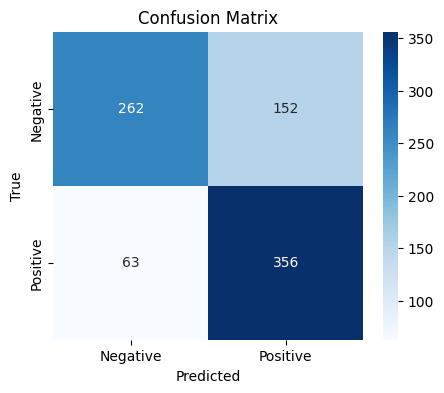

Report:
              precision    recall  f1-score   support

    Negative       0.81      0.63      0.71       414
    Positive       0.70      0.85      0.77       419

    accuracy                           0.74       833
   macro avg       0.75      0.74      0.74       833
weighted avg       0.75      0.74      0.74       833

ROC AUC Score: 0.8105334763008312


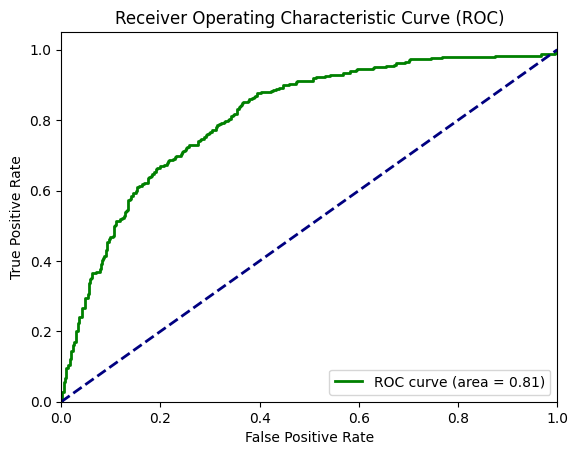

PR AUC Score: 0.7861041935751075


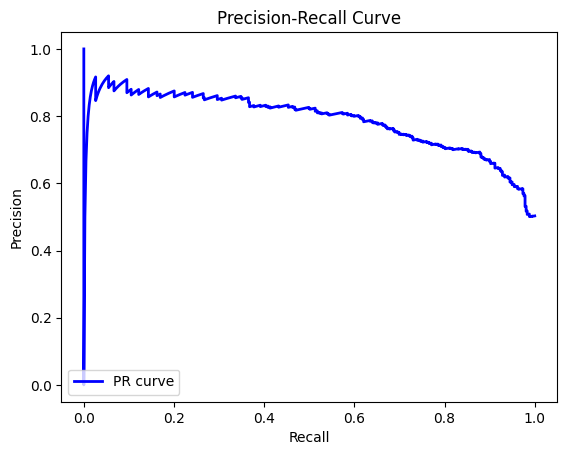

In [ ]:
predictions_nn = model_nn.predict(test_images)
predicted_classes_nn = (predictions_nn > 0.5).astype("int32")
true_classes_nn = test_labels.astype("int32")
conf_matrix = confusion_matrix(true_classes_nn, predicted_classes_nn)
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print("Report:")
print(classification_report(true_classes_nn, predicted_classes_nn, target_names=['Negative', 'Positive']))


#ROC
roc_auc = roc_auc_score(true_classes_nn, predictions_nn)
print(f"ROC AUC Score: {roc_auc}")
f_p_r, t_p_r, thresholds = roc_curve(true_classes_nn, predictions_nn)
plt.figure()
plt.plot(f_p_r, t_p_r, color='green', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve (ROC)')
plt.legend(loc="lower right")
plt.show()

#PRC
precision_vals, recall_vals, _ = precision_recall_curve(true_classes_nn, predictions_nn)
pr_auc = auc(recall_vals, precision_vals)
print(f"PR AUC Score: {pr_auc}")
plt.figure()
plt.plot(recall_vals, precision_vals, color='blue', lw=2, label='PR curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()

Since lstm is suitable for time series data, the images are reshaped according to the model. Sequential function is used to initiate layers, Two LSTM blocks with 128 units have been used with a drop out of 0.25 and two dense layers with 64 neurons and 1 neuron are used. Binary crossentropy is used for loss function.


In [ ]:
num_samples = augmented_images.shape[0]
height = augmented_images.shape[1]
width = augmented_images.shape[2]
channels = augmented_images.shape[3]

def create_lstm_model(optimizer, learning_rate):
        set_seed(42)
        optimizers_dict = {
              'adam': Adam,
              'sgd': SGD,
              'rmsprop': RMSprop,
              'Adagrad': Adagrad
            }
        model_lstm = Sequential()
        model_lstm.add(LSTM(128, input_shape=(height * width, channels), return_sequences=True))
        model_lstm.add(Dropout(0.25))
        model_lstm.add(LSTM(128))
        model_lstm.add(Dense(64, activation='relu'))
        model_lstm.add(Dropout(0.25))
        model_lstm.add(Dense(1, activation='sigmoid'))
        optimizer_class = optimizers_dict[optimizer]
        optimizer = optimizer_class(learning_rate=learning_rate)
        model_lstm.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer=optimizer)
        return model_lstm

**LSTM Hyperparameter Tuning**
KerasClassifier and GridSearchCV function is used, with epoch set to 2 learning rate of 0.0001, 0.00001 and optimizers adam, rmsprop, sgd and Adagrad have been tested. 2-fold cross validation is used.


In [ ]:
augmented_images_reshaped = augmented_images.reshape(num_samples, height * width, channels)
num_val_samples = val_images.shape[0]
val_images_reshaped = val_images.reshape(num_val_samples, height * width, channels)

model_lstm_tune = KerasClassifier(build_fn=create_lstm_model, verbose=1)
params={
    'epochs':[2],
    'model__optimizer':['adam','rmsprop','sgd','Adagrad'],
    'model__learning_rate':[0.0001,0.00001],
    }
search=GridSearchCV(estimator=model_lstm_tune, param_grid=params, cv=2, verbose=3)
search = search.fit(augmented_images_reshaped, augmented_labels)

best_params_lstm = search.best_params_
print("Best Parameters: ", best_params_lstm)

Fitting 2 folds for each of 1 candidates, totalling 2 fits


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/2
243/243 ━━━━━━━━━━━━━━━━━━━━ 34s 132ms/step - accuracy: 0.6600 - loss: 0.6104
Epoch 2/2
243/243 ━━━━━━━━━━━━━━━━━━━━ 32s 133ms/step - accuracy: 0.7365 - loss: 0.5300
243/243 ━━━━━━━━━━━━━━━━━━━━ 13s 55ms/step
[CV 1/2] END epochs=2, model__learning_rate=0.0001, model__optimizer=adam;, score=0.748 total time= 1.3min


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/2
243/243 ━━━━━━━━━━━━━━━━━━━━ 35s 134ms/step - accuracy: 0.6708 - loss: 0.6136
Epoch 2/2
243/243 ━━━━━━━━━━━━━━━━━━━━ 33s 134ms/step - accuracy: 0.7463 - loss: 0.5300
243/243 ━━━━━━━━━━━━━━━━━━━━ 13s 54ms/step
[CV 2/2] END epochs=2, model__learning_rate=0.0001, model__optimizer=adam;, score=0.742 total time= 1.3min


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/2
 92/486 ━━━━━━━━━━━━━━━━━━━━ 53s 135ms/step - accuracy: 0.6202 - loss: 0.6492

KeyboardInterrupt: 


**LSTM Training**
LSTM model is trained with epoch 2, batch size 32, optimizer adam and learning rate set to 0.0001. Validation dataset is used to validate training accuracy.


In [ ]:
num_val_samples = val_images.shape[0]
val_images_reshaped = val_images.reshape(num_val_samples, height * width, channels)
model_lstm_train = create_lstm_model(optimizer='adam', learning_rate= 0.0001)
model_lstm_train.fit(augmented_images_reshaped, augmented_labels, epochs=2, verbose=1,validation_data=(val_images_reshaped, val_labels), batch_size=32)

Epoch 1/2
486/486 ━━━━━━━━━━━━━━━━━━━━ 69s 138ms/step - accuracy: 0.6990 - loss: 0.5809 - val_accuracy: 0.7548 - val_loss: 0.5021
Epoch 2/2
486/486 ━━━━━━━━━━━━━━━━━━━━ 67s 139ms/step - accuracy: 0.7454 - loss: 0.5150 - val_accuracy: 0.7500 - val_loss: 0.5067


**LSTM Evaluation**
73% accuracy is obtained by evaluating the model with test data.


In [ ]:
num_test_images = test_images.shape[0]
test_images_reshaped = test_images.reshape(num_test_images, height * width, channels)

test_loss, test_accuracy = model_lstm_train.evaluate(test_images_reshaped, test_labels, verbose=1)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.7503 - loss: 0.5092
Test Loss: 0.5224608778953552
Test Accuracy: 0.7334933876991272


**LSTM Performance**
The recall for positive class at 0.85 and precision at 0.66 indicates the models strong ability to capture positive cases, high f1 score also shows that the performance is balanced.ROC AUC score and PR AUC score shows that the model is performing well without any overfitting. Overall accuracy is also good at 70%


27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step


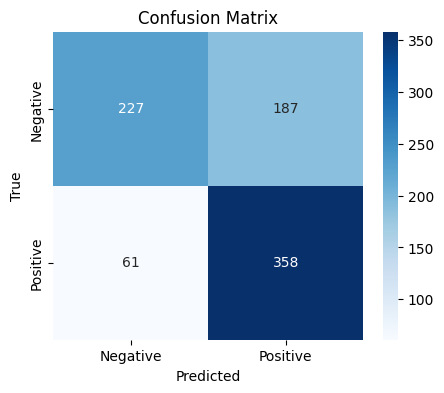

Report:
              precision    recall  f1-score   support

    Negative       0.79      0.55      0.65       414
    Positive       0.66      0.85      0.74       419

    accuracy                           0.70       833
   macro avg       0.72      0.70      0.69       833
weighted avg       0.72      0.70      0.70       833

ROC AUC Score: 0.8107006560363414


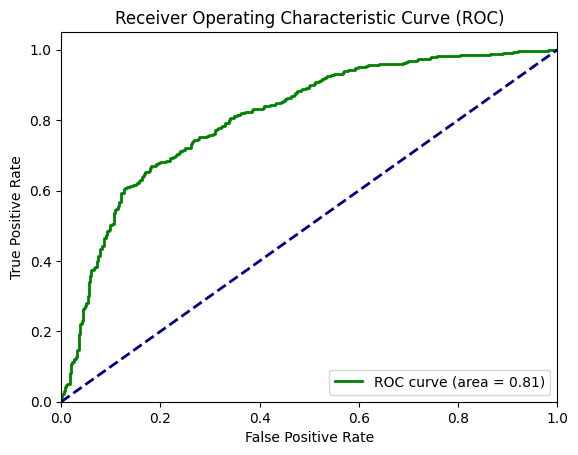

PR AUC Score: 0.7832486184404355


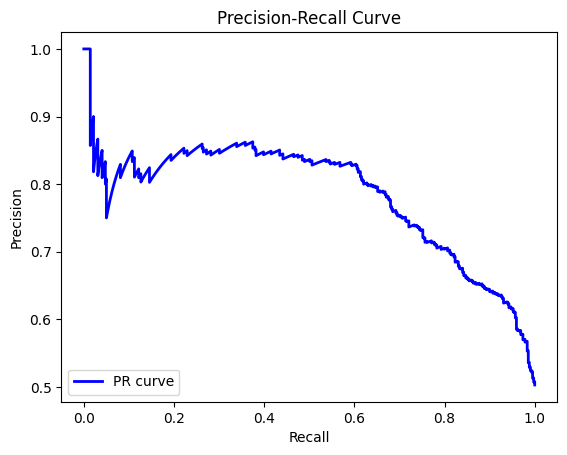

In [ ]:
num_test_images = test_images.shape[0]
test_images_reshaped = test_images.reshape(num_test_images, height * width, channels)
predictions_lstm = model_lstm_train.predict(test_images_reshaped)
predicted_classes_lstm = (predictions_lstm > 0.5).astype("int32")
true_classes_lstm = test_labels.astype("int32")
conf_matrix = confusion_matrix(true_classes_lstm, predicted_classes_lstm)
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print("Report:")
print(classification_report(true_classes_lstm, predicted_classes_lstm, target_names=['Negative', 'Positive']))


#ROC
roc_auc = roc_auc_score(true_classes_lstm, predictions_lstm)
print(f"ROC AUC Score: {roc_auc}")
f_p_r, t_p_r, thresholds = roc_curve(true_classes_lstm, predictions_lstm)
plt.figure()
plt.plot(f_p_r, t_p_r, color='green', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve (ROC)')
plt.legend(loc="lower right")
plt.show()

#PRC
precision_vals, recall_vals, _ = precision_recall_curve(true_classes_lstm, predictions_lstm)
pr_auc = auc(recall_vals, precision_vals)
print(f"PR AUC Score: {pr_auc}")
plt.figure()
plt.plot(recall_vals, precision_vals, color='blue', lw=2, label='PR curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()

**Random Forest Model Training**
The images are reshaped according to the model architecture, The parameters are trained for 300 trees, minimum samples is split at 2, entropy criterion is used. Warm_start is set to true to view the progress of the model. An accuracy of 74.2% is obtained for the testing dataset.


In [ ]:
print(augmented_images.shape)
print(test_images.shape)
augmented_images_reshaped = augmented_images.reshape(15528, -1)
test_images_reshaped = test_images.reshape(833, -1)
print(augmented_images_reshaped.shape)
print(test_images_reshaped.shape)

set_seed(42)
best_params = {
    'n_estimators': 300,
    'min_samples_split': 2,
    'min_samples_leaf': 1,
    'max_depth': 100,
    'criterion': 'entropy',
    'class_weight': None,
    'bootstrap': True
}
rf_best_model = RandomForestClassifier(
    warm_start=True,
    n_jobs=-1,
    **best_params
)
for i in range(1, best_params['n_estimators'] + 1):
        rf_best_model.set_params(n_estimators=i)
        rf_best_model.fit(augmented_images_reshaped, augmented_labels)
        if i % 3 == 0:
            print(f"{i} trees have been trained so far.")

y_pred = rf_best_model.predict(test_images_reshaped)
print("Best parameters")
print(rf_best_model.get_params())
acc = '{:.1%}'.format(accuracy_score(test_labels, y_pred))
print(f"Accuracy: {acc}")

(15528, 50, 50, 3)
(833, 50, 50, 3)
(15528, 7500)
(833, 7500)
3 trees have been trained so far.
6 trees have been trained so far.
9 trees have been trained so far.
12 trees have been trained so far.
15 trees have been trained so far.
18 trees have been trained so far.
21 trees have been trained so far.
24 trees have been trained so far.
27 trees have been trained so far.
30 trees have been trained so far.
33 trees have been trained so far.
36 trees have been trained so far.
39 trees have been trained so far.
42 trees have been trained so far.
45 trees have been trained so far.
48 trees have been trained so far.
51 trees have been trained so far.
54 trees have been trained so far.
57 trees have been trained so far.
60 trees have been trained so far.
63 trees have been trained so far.
66 trees have been trained so far.
69 trees have been trained so far.
72 trees have been trained so far.
75 trees have been trained so far.
78 trees have been trained so far.
81 trees have been trained so f

**Random Forest Model Performance**
Both precision and recall for both positive and negative classes are balanced indicating a balanced performance. The ROC AUC score, PR AUC score is also high and with overall accuracy of 74% indicates that the model is giving good performance. F1 score is also in the acceptable range shows that the model does not go through overfitting.


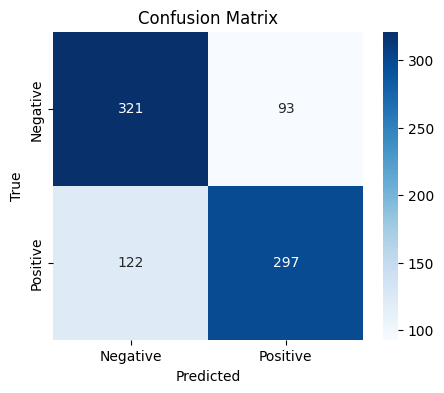

Report:
              precision    recall  f1-score   support

    Negative       0.72      0.78      0.75       414
    Positive       0.76      0.71      0.73       419

    accuracy                           0.74       833
   macro avg       0.74      0.74      0.74       833
weighted avg       0.74      0.74      0.74       833

ROC AUC Score: 0.8245621620375174


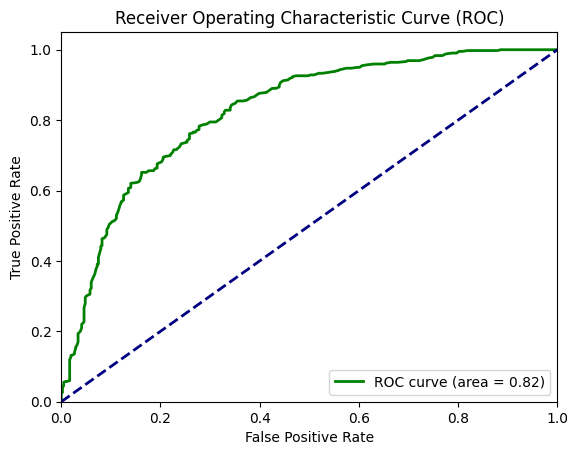

PR AUC Score: 0.7974557608298246


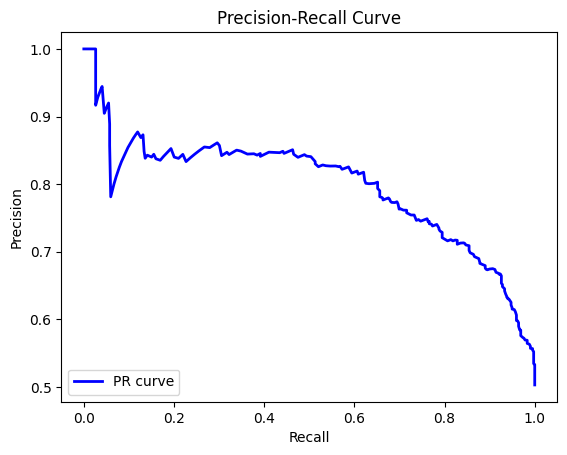

In [ ]:
predicted_classes_rf = y_pred
true_classes_rf = test_labels

# Confusion Matrix
conf_matrix = confusion_matrix(true_classes_rf, predicted_classes_rf)
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print("Report:")
print(classification_report(true_classes_rf, predicted_classes_rf, target_names=['Negative', 'Positive']))

# ROC Curve and AUC
probabilities_rf = rf_best_model.predict_proba(test_images_reshaped)[:, 1]
roc_auc = roc_auc_score(true_classes_rf, probabilities_rf)
print(f"ROC AUC Score: {roc_auc}")
f_p_r, t_p_r, thresholds = roc_curve(true_classes_rf, probabilities_rf)
plt.figure()
plt.plot(f_p_r, t_p_r, color='green', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve (ROC)')
plt.legend(loc="lower right")
plt.show()

# Precision-Recall Curve and AUC
precision_vals, recall_vals, _ = precision_recall_curve(true_classes_rf, probabilities_rf)
pr_auc = auc(recall_vals, precision_vals)
print(f"PR AUC Score: {pr_auc}")
plt.figure()
plt.plot(recall_vals, precision_vals, color='blue', lw=2, label='PR curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()


**KNN Model, Tuning**
The images are reshaped according to the model architecture, the model is trained on the parameters, n_neighbors 3,10,30 , weights uniform and distance and algorithm kd_tree and brute.
The gridsearchCv method is used for tuning and the model is trained with the best parameters. The model obtained an accuracy of 73% on test dataset.


In [ ]:
num_samples, height, width, channels = augmented_images.shape
augmented_images_reshaped = augmented_images.reshape(num_samples, height * width * channels)
num_samples_test, height_test, width_test, channels_test = test_images.shape
test_images_reshaped = test_images.reshape(num_samples_test, height_test * width_test * channels_test)
params = {
    'n_neighbors': [3,10,30],
    'weights': ['uniform', 'distance'],
    'algorithm': ['kd_tree', 'brute'],
}
knn = KNeighborsClassifier()
search = GridSearchCV(estimator=knn, param_grid=params, cv=2, n_jobs=-1, scoring='accuracy', verbose=3)
search.fit(augmented_images_reshaped, augmented_labels)
best_params = search.best_params_
best_score = search.best_score_

print(f"Best parameters found: {best_params}")
best_knn = search.best_estimator_
y_pred_knn = best_knn.predict(test_images_reshaped)

Fitting 2 folds for each of 12 candidates, totalling 24 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


Best parameters found: {'algorithm': 'kd_tree', 'n_neighbors': 30, 'weights': 'distance'}


In [ ]:
print(f"Best cross-validation accuracy: {best_score:.4f}")


Best cross-validation accuracy: 0.7304


**KNN Training**
The model is trained on the tuned parameters algorithm kd_tree, n_neighbors 30 and weights distance


In [ ]:
knn_model = KNeighborsClassifier(algorithm='kd_tree', n_neighbors=30, weights='distance')
knn_model.fit(augmented_images_reshaped, augmented_labels)


KNeighborsClassifier(algorithm='kd_tree', n_neighbors=30, weights='distance')

In [ ]:
y_pred = knn_model.predict(test_images_reshaped)
y_prob = knn_model.predict_proba(test_images_reshaped)[:, 1]

**KNN Performance**
Recall for the positive class is lesser than the negative class indicates that the model performs better for negative class than positive class. F1 score is comparatively similar and accuracy is at 72% indicating good overall performance. The ROC AUC score and PR AUC curve scores are high indicating there is not much overfitting in the model.


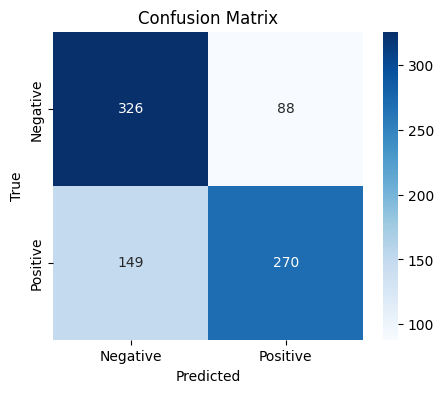

Report:
              precision    recall  f1-score   support

    Negative       0.69      0.79      0.73       414
    Positive       0.75      0.64      0.69       419

    accuracy                           0.72       833
   macro avg       0.72      0.72      0.71       833
weighted avg       0.72      0.72      0.71       833

ROC AUC Score: 0.7803085330842933


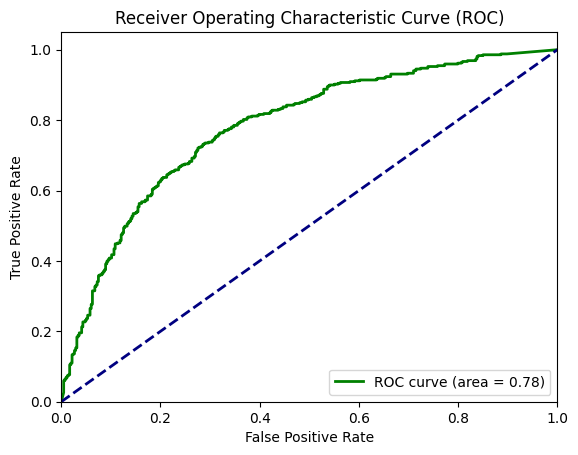

PR AUC Score: 0.7625777108020529


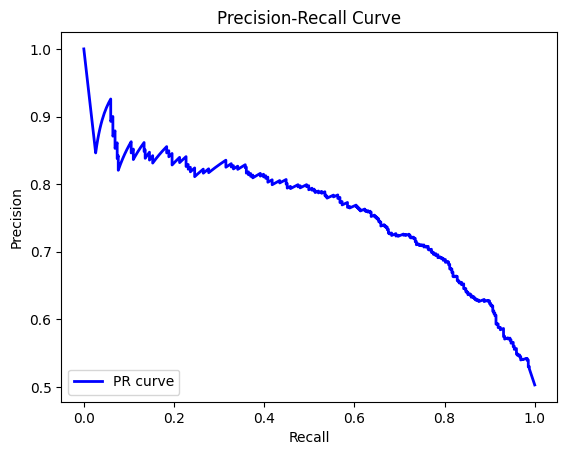

In [ ]:
# Calculate metrics
predicted_classes_knn = y_pred
true_classes_knn = test_labels

# Confusion Matrix
conf_matrix = confusion_matrix(true_classes_knn, predicted_classes_knn)
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print("Report:")
print(classification_report(true_classes_knn, predicted_classes_knn, target_names=['Negative', 'Positive']))

# ROC Curve and AUC
roc_auc = roc_auc_score(true_classes_knn, y_prob)
print(f"ROC AUC Score: {roc_auc}")
f_p_r, t_p_r, thresholds = roc_curve(true_classes_knn, y_prob)
plt.figure()
plt.plot(f_p_r, t_p_r, color='green', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve (ROC)')
plt.legend(loc="lower right")
plt.show()

# Precision-Recall Curve and AUC
precision_vals, recall_vals, _ = precision_recall_curve(true_classes_knn, y_prob)
pr_auc = auc(recall_vals, precision_vals)
print(f"PR AUC Score: {pr_auc}")
plt.figure()
plt.plot(recall_vals, precision_vals, color='blue', lw=2, label='PR curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()

**Naïve Bayes Model and Tuning**
The var_smoothing parameter is checked for the perfect tuning of the model, the images are reshaped according to the model architecture. GridSearchCv is used for model tuning.


In [ ]:
num_samples, height, width, channels = augmented_images.shape
augmented_images_reshaped = augmented_images.reshape(num_samples, height * width * channels)
num_samples_test, height_test, width_test, channels_test = test_images.shape
test_images_reshaped = test_images.reshape(num_samples_test, height_test * width_test * channels_test)

nb=GaussianNB()
params = {
    'var_smoothing': np.logspace(0, -9, num=100)
}
search = GridSearchCV(estimator=nb, param_grid=params, cv=2, n_jobs=-1, scoring='accuracy')
search.fit(augmented_images_reshaped, augmented_labels)

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


GridSearchCV(cv=2, estimator=GaussianNB(), n_jobs=-1,
             param_grid={'var_smoothing': array([1.00000000e+00, 8.11130831e-01, 6.57933225e-01, 5.33669923e-01,
       4.32876128e-01, 3.51119173e-01, 2.84803587e-01, 2.31012970e-01,
       1.87381742e-01, 1.51991108e-01, 1.23284674e-01, 1.00000000e-01,
       8.11130831e-02, 6.57933225e-02, 5.33669923e-02, 4.32876128e-02,
       3.51119173e-02, 2.8480358...
       1.23284674e-07, 1.00000000e-07, 8.11130831e-08, 6.57933225e-08,
       5.33669923e-08, 4.32876128e-08, 3.51119173e-08, 2.84803587e-08,
       2.31012970e-08, 1.87381742e-08, 1.51991108e-08, 1.23284674e-08,
       1.00000000e-08, 8.11130831e-09, 6.57933225e-09, 5.33669923e-09,
       4.32876128e-09, 3.51119173e-09, 2.84803587e-09, 2.31012970e-09,
       1.87381742e-09, 1.51991108e-09, 1.23284674e-09, 1.00000000e-09])},
             scoring='accuracy')

**Naïve Bayes  Model Evaluation**
The model gets an accuracy of 71% for the best parameters.


In [ ]:
best_params = search.best_params_
best_score = search.best_score_

print(f"Best parameters found: {best_params}")
print(f"Best cross-validation accuracy: {best_score:.4f}")

Best parameters found: {'var_smoothing': 0.008111308307896872}
Best cross-validation accuracy: 0.7127


In [ ]:
best_nb = search.best_estimator_
y_pred_nb = best_nb.predict(test_images_reshaped)

**Naïve Bayes  Model Performance**
The recall for positive class is lesser than negative class, indicates that the model performs better for positive class. The F1 scores, AU ROC curve scores and PR ROC scores are in the acceptable range indicating good overall performance of the model. The overall accuracy is also at 70%.


Accuracy: 0.6975
Confusion Matrix:
[[304 110]
 [142 277]]
Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.73      0.71       414
           1       0.72      0.66      0.69       419

    accuracy                           0.70       833
   macro avg       0.70      0.70      0.70       833
weighted avg       0.70      0.70      0.70       833



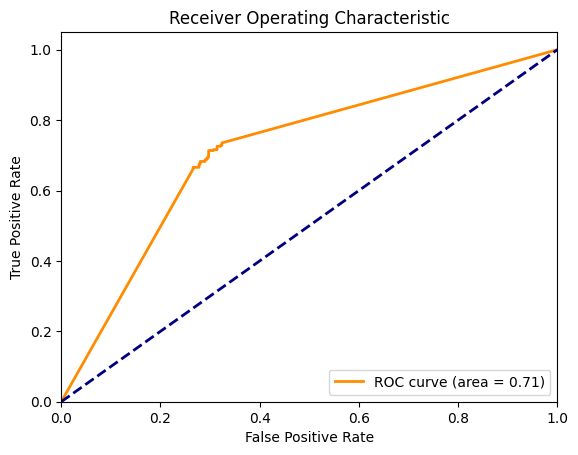

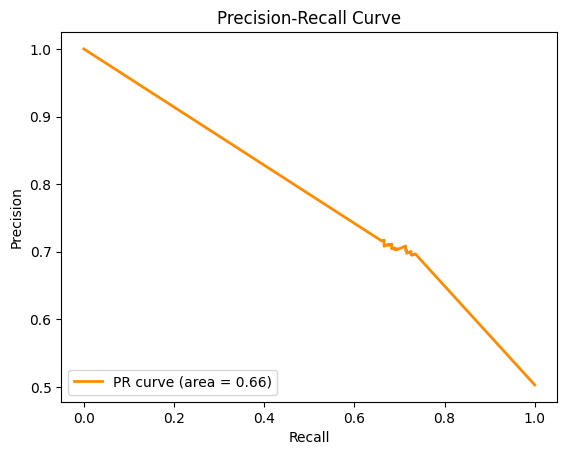

In [ ]:
# Calculate accuracy
accuracy = accuracy_score(test_labels, y_pred_nb)
print(f'Accuracy: {accuracy:.4f}')

# Generate confusion matrix
conf_matrix = confusion_matrix(test_labels, y_pred_nb)
print('Confusion Matrix:')
print(conf_matrix)

# Generate classification report
class_report = classification_report(test_labels, y_pred_nb)
print('Classification Report:')
print(class_report)

y_pred_prob_nb = best_nb.predict_proba(test_images_reshaped)
fpr, tpr, _ = roc_curve(test_labels, y_pred_prob_nb[:, 1])
roc_auc = auc(fpr, tpr)

# Generate Precision-Recall curve values
precision, recall, _ = precision_recall_curve(test_labels, y_pred_prob_nb[:, 1])
average_precision = average_precision_score(test_labels, y_pred_prob_nb[:, 1])

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

# Plot Precision-Recall curve
plt.figure()
plt.plot(recall, precision, color='darkorange', lw=2, label=f'PR curve (area = {average_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()


**CRITICAL EVALUATION**

---



---



Model	Accuracy	Precision (Negative)	Recall (Negative)	F1-Score (Negative)	Precision (Positive)	Recall (Positive)	F1-Score (Positive)	ROC AUC Score


Naive Bayes	0.6975	0.68	0.73	0.71	0.72	0.66	0.69	0.71

KNN	0.72	0.69	0.79	0.73	0.75	0.64	0.69	0.7803

Random Forest	0.74	0.72	0.78	0.75	0.76	0.71	0.73	0.8246

LSTM	0.70	0.79	0.55	0.65	0.66	0.85	0.74

ANN	0.74	0.81	0.63	0.71	0.7	0.85	0.77	0.8105

CNN	0.65	0.91	0.32	0.47	0.59	0.97	0.73	0.8114

CNN_LSTM	0.72	0.67	0.86	0.75	0.81	0.58	0.67	0.8114


In terms of accuracy and overall performance random forest seems to take the lead with balanced metrics and high accuracy.
It is surprising that ANN with its simple architecture performed better than the model architectures with CNN.
This shows that the dataset is simple and there are not much complex variables to decipher. So simple architectures like machine learning performed good. Vanilla LSTM with its sequential prediction performed better than vanilla CNN.
 But since this is a medical dataset the cost of false positives is very high so we have to go with the model which gives the best positive recall. Although CNN’s positive recall is very high it comes at the cost of its negative recall. To get a more balanced performance and also with high positive recall we will go with the ANN model as the chosen model
